In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from numpy import array, linspace, dot
from IPython.display import display, Latex
from sympy import Symbol, latex, integrate, init_printing, log, sqrt, atan

init_printing()
x = Symbol('x')

# План

1. Постановка задачи;
2. Аппроксимация полиномами:
    - Интегральный МНК;
    - Интегральный МНК по ортогональной системе;
    - Точечный МНК;
3. Аппроксимация сплайнами;
4. Сравнение методов и выводы.

# Постановка задачи

## Add text


Все методы будем иллюстрировать на следующем примере:

In [2]:
f = atan(1 / x**2) - x
a, b = [-1.5, -0.5]
N1, N2, n = [2, 3, 10]
nodes = linspace(a, b, n+1)

# Аппроксимация полиномами 

### Интегральный МНК 

Начнём мы с более теоретического случая, когда у нас задана функция целиком, аналитически. Работать будем в Гильбертовом пространстве $L_{2, \rho}\big[a; b\big]$ - пространстве квадратично суммируемых по Лебегу функций (таких, что $(L) \int\limits_a^b \rho(x) f^2(x) dx < +\infty$). В дальнейшем мы будем рассматривать единичный вес, однако несколько мыслей для наиболее распрастраненных весовых функций будет высказано в следующем пункте. 

_Напоминание_: скалярное произведение и норма в этом пространстве задаются выражениями $(f, g)_{\rho}=\int \limits_a^b f(x)g(x)dx$ и $\|f\|_{\rho}=\sqrt{(f, f)}$. (Для единичного веса нижний индекс указывать не будем).

Для начала нам стоит выбрать какой-нибудь базис пространства - $\{\varphi_k\}_{k=0}^{\infty}$ (например, система $\{1, x, x^2, ...\}$). Как мы знаем, любая функция из пространства теперь может быть разложена в ряд Фурье по этому базису, но там бесконечная сумма, которую мы вычислительно никак обрабатывать не можем. Да и не хотим. Хотим упростить себе жизнь и взять лишь первые $N+1$ слагаемых из этого ряда, таким образом, аппроксимирующая функция будет иметь вид $\Phi_N(x)=\sum\limits_{k=0}^N c_k \varphi_k(x)$. А вот этот вектор коэффициентов $\mathbf{c}=(c_0, c_1, ... c_N)$ мы и хотим подобрать оптимально так, чтобы (вспоминаем название метода) квадрат расстояния между аппроксимирующей и аппроксимируемой функциями $\delta_N^2(\mathbf{c})$ был минимален:

$$\mathbf{c}^* = \arg \min_{\mathbf{c}\in\mathbb{R}^{n+1}} \delta_N^2(\mathbf{c}) = \arg \min_{\mathbf{c}\in\mathbb{R}^{n+1}} \| f - \Phi_N\|^2.$$

Из геометрических соображений мы понимаем, что ошибка будет минимальной, если она будет ортогональна подпространству, порождаемому выбранной подсистемой базисных функций (т.е. всем возможным функциям $\Phi_N$), что приводит нас к такой СЛАУ:

$$\begin{cases} \sum\limits_{k=0}^N c_k (\varphi_k, \varphi_0) = (f, \varphi_0),\\
                \sum\limits_{k=0}^N c_k (\varphi_k, \varphi_1) = (f, \varphi_1),\\
                ...\\
                \sum\limits_{k=0}^N c_k (\varphi_k, \varphi_N) = (f, \varphi_N).
\end{cases}$$

Так, $(\varphi_i, \varphi_j) = \int\limits_a^b x^{i+j}dx = \frac{b^{i+j+1} - a ^{i+j+1}}{i+j+1}$, матрицу из этих элементов обозначим $A$ (_матрица Грамма системы функций_). Обозначим также $b_i = (f, \varphi_i) = \int\limits_a^b f(x) x^i dx$, $\mathbf{b}=[b_0, ... b_N]^T$, тогда оптимальный вектор коэффициентов ИМНК будет представляться решением системы

$$A \mathbf{c} = \mathbf{b},$$

которая всегда имеет решение ввиду линейной независимости функций $\varphi_k$.

Для оценки точности мы величину ошибки аппроксимации нормируем на длину отрезка и извлекаем корень, в итоге получая величину $$\sigma_N = \sqrt{\frac{\delta_N^2}{b-a}}.$$

In [3]:
def integral_poly_ls(func, a, b, N, ret_coef=False, ret_error=False):
    
    A = array([[(b**(i+j+1) - a**(i+j+1)) / (i + j + 1) for j in range(N+1)] for i in range(N+1)])
    B = array([quad(lambda x0: (func * x**i).subs(x, x0), a, b)[0] for i in range(N+1)])
    c = np.linalg.solve(A, B) 
    
    if ret_error:
        Phi = sum([c[k]*x**k for k in range(N+1)])
        sig = sigma_approx_cont(func, Phi, a, b)
        if ret_coef:
            return c, sig
        return Phi, sig
    
    if ret_coef:
        return c
    return Phi

def sigma_approx_cont(f, Phi, a, b):
    e2 = (f - Phi)**2
    delta2 = quad(lambda x0: e2.subs(x, x0), a, b)[0]
    return (delta2 / (b-a))**0.5

##### Пункт 2 - ИМНК по обыкновенным полиномам 2-го и 3-го порядка 

In [4]:
Phi2, sigma2 = integral_poly_ls(f, a, b, N1, ret_error=True)
Phi3, sigma3 = integral_poly_ls(f, a, b, N2, ret_error=True)
display(Latex('$\Phi_2(x) = ' + latex(Phi2) + ', \sigma_2 = %.2e.$' % sigma2))
display(Latex('$\Phi_3(x) = ' + latex(Phi3) + ', \sigma_3 = %.2e.$' % sigma3))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


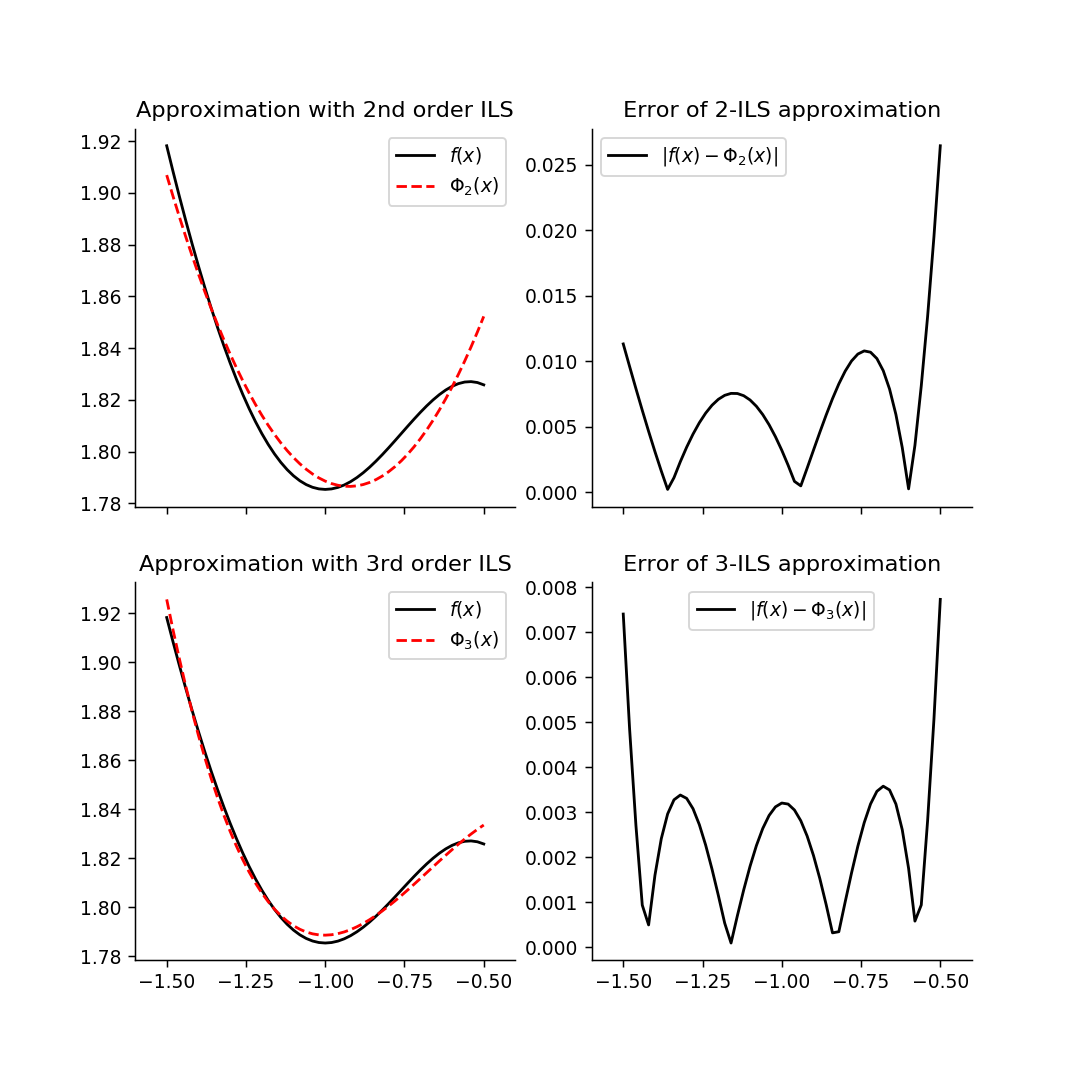

In [5]:
x_grid = linspace(a, b, 51)
f_grid = array([f.subs(x, xi) for xi in x_grid])
Phi2_grid = array([Phi2.subs(x, xi) for xi in x_grid])
Phi2_err_grid = np.abs(f_grid - Phi2_grid)
Phi3_grid = array([Phi3.subs(x, xi) for xi in x_grid])
Phi3_err_grid = np.abs(f_grid - Phi3_grid)

fig1, axes1 = plt.subplots(2, 2, sharex=True, figsize=(8, 8))
axes1[0, 0].set_xlim(a-0.1, b + 0.1)

for ax in axes1.flatten():
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')


axes1[0, 0].plot(x_grid, f_grid, color='black', label='$f(x)$')
axes1[0, 0].plot(x_grid, Phi2_grid, '--', color='red', label='$\Phi_2(x)$')
axes1[0, 0].set_title('Approximation with 2nd order ILS')
axes1[0, 1].plot(x_grid, Phi2_err_grid, color='black', label='$|f(x)-\Phi_2(x)|$')
axes1[0, 1].set_title('Error of 2-ILS approximation')
axes1[0, 0].legend();
axes1[0, 1].legend()

axes1[1, 0].plot(x_grid, f_grid, color='black', label='$f(x)$')
axes1[1, 0].plot(x_grid, Phi3_grid, '--', color='red', label='$\Phi_3(x)$')
axes1[1, 0].set_title('Approximation with 3rd order ILS')
axes1[1, 1].plot(x_grid, Phi3_err_grid, color='black', label='$|f(x)-\Phi_3(x)|$')
axes1[1, 1].set_title('Error of 3-ILS approximation')
axes1[1, 0].legend();
axes1[1, 1].legend();

### Интегральный МНК по ортогональной системе полиномов

_Напоминание_: система полиномов $\{P_k(x)\}_{k=0}^{N}$ называется ортонормированной с весом $\rho$, если произвольные полиномы различных порядков ортогональны друг другу, а норма каждого из полиномов равна 1 (если выполнено лишь первое условие, система называется ортогональной). Формальным языком, 

$$(P_i, P_j)_{\rho} = \int \limits_a^b \rho(x) P_i(x) P_j(x) dx = \begin{cases} 1,  i = j, \\ 0,  i \neq j. \end{cases}$$

Итак, зачем нам вообще это рассматривать? Две причины. Во-первых, матрицы систем из предыдущего пункта обычно очень плохо обусловлены. Во-вторых, потому что в случае ортонормированности системы полиномов у нас даже не возникнет СЛАУ (точнее, тривиальная), оптимальные коэффициенты можно будет просто найти по формуле для коэффициентов Фурье:

$$c_k^*=\frac{(f, P_k)_{\rho}}{(P_k, P_k)_{\rho}}.$$

Ошибка аппроксимации при этом тоже считается по простой формуле $\delta_N^2 = \|f\|_{\rho}^2 - \sum \limits_{k=0}^N (c_k^*)^2 \|P_k\|_{\rho}^2$.

Здесь я приведу ортогональные системы многочленов для разных весовых функций.

1. $L_{\rho}(-1; 1)$, $\rho(x)=(1-x)^{\alpha}(1+x)^{\beta}, \alpha, \beta >-1$ - [многочлены Якоби](https://ru.wikipedia.org/wiki/%D0%9C%D0%BD%D0%BE%D0%B3%D0%BE%D1%87%D0%BB%D0%B5%D0%BD%D1%8B_%D0%AF%D0%BA%D0%BE%D0%B1%D0%B8) $P_n^{(\alpha, \beta)}(x)$.
2. $L_{\rho}(-1; 1)$, $\rho(x)\equiv1$ - [многочлены Лежандра](https://ru.wikipedia.org/wiki/%D0%9C%D0%BD%D0%BE%D0%B3%D0%BE%D1%87%D0%BB%D0%B5%D0%BD%D1%8B_%D0%9B%D0%B5%D0%B6%D0%B0%D0%BD%D0%B4%D1%80%D0%B0) $P_n(x)$ (Якоби с $\alpha=\beta=0$).
3.  $L_{\rho}(-1; 1)$, $\rho(x)=\frac{1}{\sqrt{1-x^2}}$ - [многочлены Чебышева первого рода](https://ru.wikipedia.org/wiki/%D0%9C%D0%BD%D0%BE%D0%B3%D0%BE%D1%87%D0%BB%D0%B5%D0%BD%D1%8B_%D0%A7%D0%B5%D0%B1%D1%8B%D1%88%D1%91%D0%B2%D0%B0) $T_n(x)$ (Якоби с $\alpha=\beta=-\frac{1}{2}$).
4.  $L_{\rho}(-1; 1)$, $\rho(x)=\sqrt{1-x^2}$ - [многочлены Чебышева второго рода](https://ru.wikipedia.org/wiki/%D0%9C%D0%BD%D0%BE%D0%B3%D0%BE%D1%87%D0%BB%D0%B5%D0%BD%D1%8B_%D0%A7%D0%B5%D0%B1%D1%8B%D1%88%D1%91%D0%B2%D0%B0) $Г_n(x)$ (Якоби с $\alpha=\beta=\frac{1}{2}$).
5.  $L_{\rho}(0; +\infty)$, $\rho(x)=x^{\alpha}e^{-x}, \alpha>-1$ - [многочлены Лагерра](https://ru.wikipedia.org/wiki/%D0%9C%D0%BD%D0%BE%D0%B3%D0%BE%D1%87%D0%BB%D0%B5%D0%BD%D1%8B_%D0%9B%D0%B0%D0%B3%D0%B5%D1%80%D1%80%D0%B0) $L_n^{(\alpha)}(x)$.
6.  $L_{\rho}(-\infty; +\infty)$, $\rho(x)=xe^{-x^2}$ - [многочлены Эрмита](https://ru.wikipedia.org/wiki/%D0%9C%D0%BD%D0%BE%D0%B3%D0%BE%D1%87%D0%BB%D0%B5%D0%BD%D1%8B_%D0%AD%D1%80%D0%BC%D0%B8%D1%82%D0%B0) $H_n(x)$.

Приятным фактом является то, что средства для работы с большей частью из этих многочленов предусмотрены в пакете `sympy`. Мы остановимся, опять-таки, лишь на единичном весе и многочленах Лежандра.

In [6]:
def integral_legendre_ls(func, a, b, N, ret_coef=False, ret_error=False):
    
    from sympy import legendre
    c = np.zeros(N+1)
    Phi = 0
    for k in range(N+1):
        lk = legendre(k, (2*x - b - a)/(b-a))
        c[k] = quad(lambda x0: (func * lk).subs(x, x0), a, b)[0] / integrate(lk*lk, (x, a, b))
        Phi += c[k] * lk
    
    if ret_error:
        sig = sigma_approx_cont(func, Phi, a, b)
        if ret_coef:
            return c, sig
        return Phi, sig
    
    if ret_coef:
        return c
    return Phi

##### Пункт 3 - ИМНК по полиномам Лежандра 2-го и 3-го порядка 

In [7]:
Phi2_leg, sigma2_leg = integral_legendre_ls(f, a, b, N1, ret_error=True)
Phi3_leg, sigma3_leg = integral_legendre_ls(f, a, b, N2, ret_error=True)
display(Latex('$\Phi_2(x) = ' + latex(Phi2_leg.simplify()) + ', \sigma_2 = %.2e.$' % sigma2_leg))
display(Latex('$\Phi_3(x) = ' + latex(Phi3_leg.simplify()) + ', \sigma_3 = %.2e.$' % sigma3_leg))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


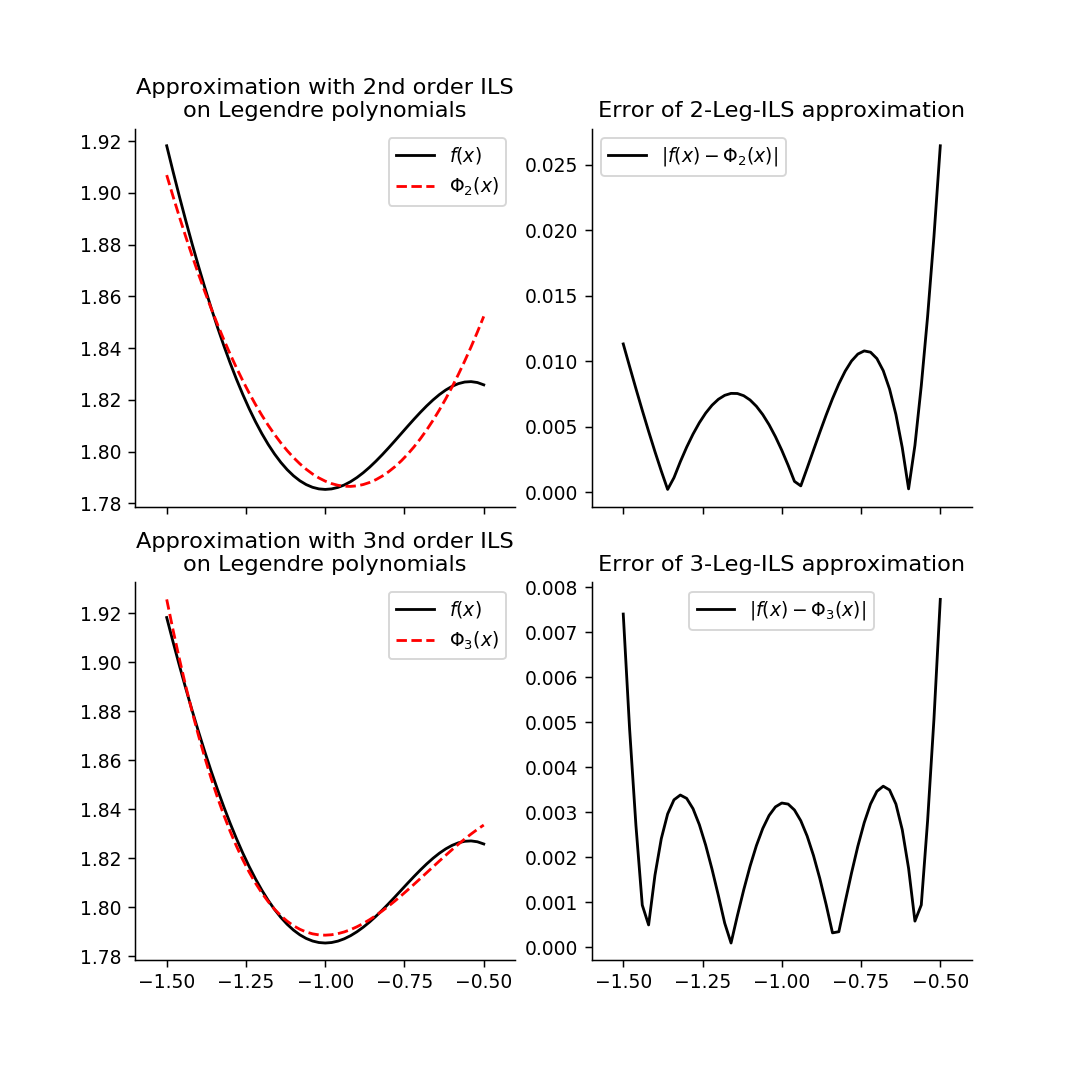

In [8]:
Phi2_leg_grid = array([Phi2.subs(x, xi) for xi in x_grid])
Phi2_leg_err_grid = np.abs(f_grid - Phi2_leg_grid)
Phi3_leg_grid = array([Phi3.subs(x, xi) for xi in x_grid])
Phi3_leg_err_grid = np.abs(f_grid - Phi3_leg_grid)

fig2, axes2 = plt.subplots(2, 2, sharex=True, figsize=(8, 8))
axes2[0, 0].set_xlim(a-0.1, b + 0.1)\

for ax in axes2.flatten():
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

axes2[0, 0].plot(x_grid, f_grid, color='black', label='$f(x)$')
axes2[0, 0].plot(x_grid, Phi2_leg_grid, '--', color='red', label='$\Phi_2(x)$')
axes2[0, 0].set_title('Approximation with 2nd order ILS\non Legendre polynomials')
axes2[0, 1].plot(x_grid, Phi2_leg_err_grid, color='black', label='$|f(x)-\Phi_2(x)|$')
axes2[0, 1].set_title('Error of 2-Leg-ILS approximation')
axes2[0, 0].legend();
axes2[0, 1].legend()

axes2[1, 0].plot(x_grid, f_grid, color='black', label='$f(x)$')
axes2[1, 0].plot(x_grid, Phi3_leg_grid, '--', color='red', label='$\Phi_3(x)$')
axes2[1, 0].set_title('Approximation with 3nd order ILS\non Legendre polynomials')
axes2[1, 1].plot(x_grid, Phi3_leg_err_grid, color='black', label='$|f(x)-\Phi_3(x)|$')
axes2[1, 1].set_title('Error of 3-Leg-ILS approximation')
axes2[1, 0].legend();
axes2[1, 1].legend();

В итоге мы получили те же самые результаты, но в этот раз более устойчивым способом.

### Точечный МНК

Вот теперь мы приближаемся к более правдоподобной ситуации: функция задана нам лишь в определённых точках таблицей. В реальности аппроксимация - это не только упрощение и попытка избежать работы с бесконечной суммой. Предположение о том, что данные немного зашумлены или получены неточно является довольно разумным, и нам очень не хочется, чтобы функция, которой мы "подменяем" истинную, слишком сильно подстраивалась под эти шумы, теряя общую картину, как будет, например, при интерполяции (в терминах машинного обучения - не хотим переобучаться). И аппроксимация - это как раз-таки способ не улавливать такие шумы благодаря отказу от необходимости равенства функций $f$ и $\Phi_N$ в заданных узлах.

Формальные выкладки остаются совершенно такими же, как и в случае ИМНК, только теперь функция задана не на отрезке $\big[a; b\big]$, а на сетке $\Omega_n = \{x_0, x_1, ..., x_n\}$, поэтому мы уже работаем, фактически, не с функциональным, а с векторным пространством. Назовём его для единообразия $L_{2,\rho}(\Omega_n)$ - пространство суммируемых с квадратом функций. Ну и как обычно происходит при переходе от функций к векторам, все интегралы нам нужно поменять на суммы. Итак, скалярное произведение в пространстве будет выглядеть так:

$$<f, g>_{\rho}=\sum_{i=0}^n \rho(x_i) f(x_i) g(x_i),$$

как будет выглядеть норма, думаю, уже понятно.

Система ТМНК вообще такая же, скобки только поменялись:

$$\begin{cases} \sum\limits_{k=0}^N c_k <\varphi_k, \varphi_0> = <f, \varphi_0>,\\
                \sum\limits_{k=0}^N c_k <\varphi_k, \varphi_1> = <f, \varphi_1>,\\
                ...\\
                \sum\limits_{k=0}^N c_k <\varphi_k, \varphi_N> = <f, \varphi_N>.
\end{cases}$$

Ну и в случае с системой функций $\{1, x, x^2, ...x_N\}$ и единичным весом получим такую СЛАУ:

$$\sum_{k=0}^N c_k \left(\sum_{i=0}^n x_i^{k+j}\right) = \sum_{i=0}^n x_i^j f(x_i), j=0,1,...N. $$

Её решение и будет оптимальным вектором коэффициентов ТМНК.

Немного изменится и ошибка аппроксимации: $\delta_N^2 = \|f-\Phi_N\|^2=\sum\limits_{i=0}^n [f(x_i)-\Phi_N(x_i)]^2$, 

$$\sigma_N = \sqrt{\frac{\delta_N^2}{n+1}}.$$

_Примечание._ Если кому-то вдруг интересно, если мы хотим рассматривать ортогональную систему многочленов, то в случае равномерной сетки мы будем масштабировать ортогональные многочлены Чебышева, о которых можно прочитать на слайде 29 в лекции по 10й теме.


In [9]:
def ordinary_ls(func, nodes, N, ret_coef=False, ret_error=False):
    
    n = len(nodes) - 1
    A = array([[dot(nodes**k, nodes**j) for j in range(N+1)] for k in range(N+1)])
    f = array([func.subs(x, nodes[i]) for i in range(n+1)])
    B = array([dot(nodes**j, f) for j in range(N+1)])
    c = dot(np.linalg.inv(A), B)
    
    if ret_error:
        Phi = sum([c[k]*x**k for k in range(N+1)])
        sig = sigma_approx_discr(func, Phi, nodes)
        if ret_coef:
            return c, sig
        return Phi, sig
    
    if ret_coef:
        return c
    return Phi

def sigma_approx_discr(func, Phi, nodes):
    e = func - Phi
    n = len(nodes) - 1
    eps = array([e.subs(x, nodes[i]) for i in range(n + 1)])
    delta2 = dot(eps, eps)
    return (delta2 / (n + 1))**0.5

In [10]:
Phi2_ols, sigma2_ols = ordinary_ls(f, nodes, N1, ret_error=True)
Phi3_ols, sigma3_ols = ordinary_ls(f, nodes, N2, ret_error=True)
display(Latex('$\Phi_2(x) = ' + latex(Phi2_ols) + ', \sigma_2 = %.2e.$' % sigma2_ols))
display(Latex('$\Phi_3(x) = ' + latex(Phi3_ols) + ', \sigma_3 = %.2e.$' % sigma3_ols))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


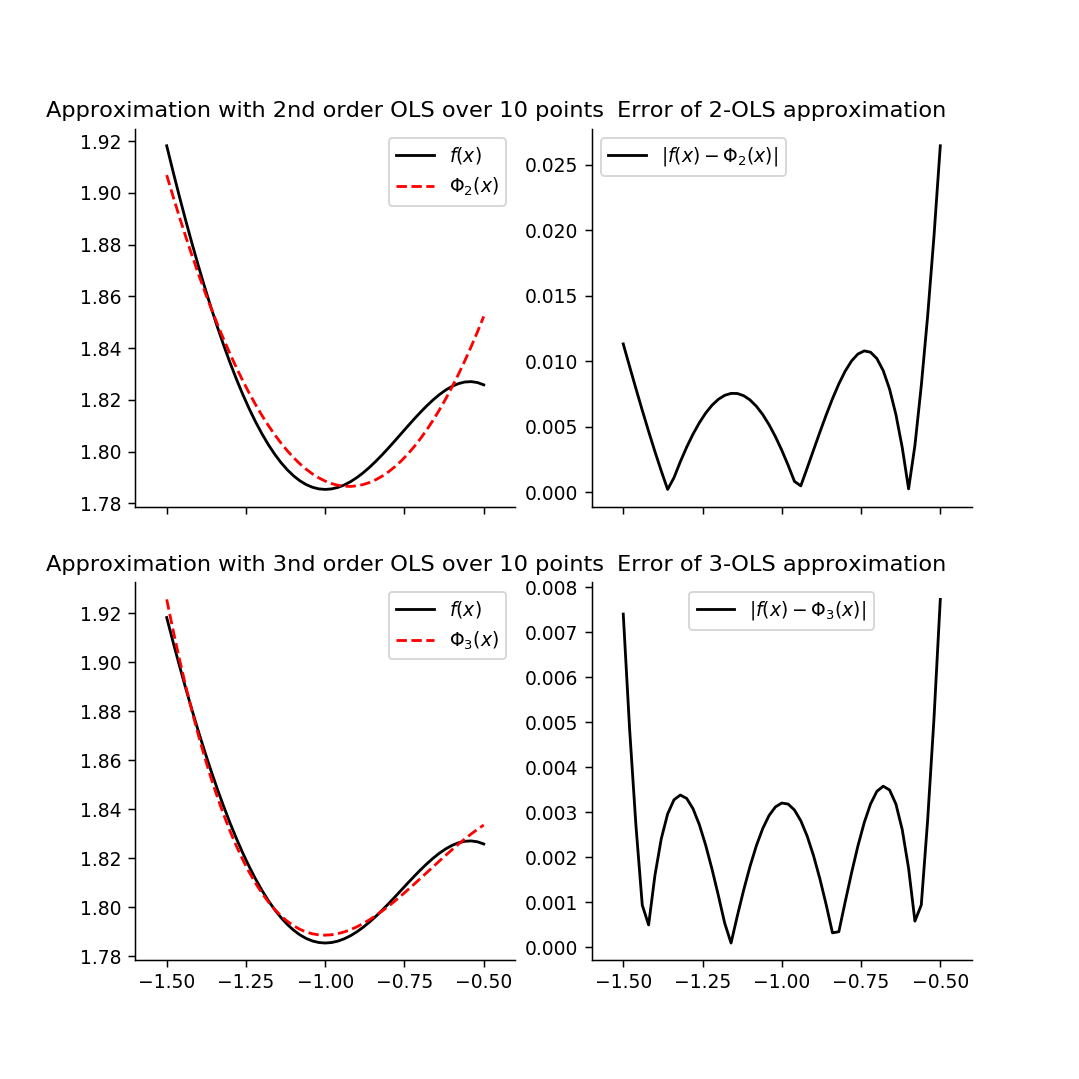

In [11]:
Phi2_ols_grid = array([Phi2.subs(x, xi) for xi in x_grid])
Phi2_ols_err_grid = np.abs(f_grid - Phi2_ols_grid)
Phi3_ols_grid = array([Phi3.subs(x, xi) for xi in x_grid])
Phi3_ols_err_grid = np.abs(f_grid - Phi3_ols_grid)

fig3, axes3 = plt.subplots(2, 2, sharex=True, figsize=(8, 8))
axes3[0, 0].set_xlim(a-0.1, b + 0.1)

for ax in axes3.flatten():
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

axes3[0, 0].plot(x_grid, f_grid, color='black', label='$f(x)$')
axes3[0, 0].plot(x_grid, Phi2_ols_grid, '--', color='red', label='$\Phi_2(x)$')
axes3[0, 0].set_title('Approximation with 2nd order OLS over 10 points')
axes3[0, 1].plot(x_grid, Phi2_ols_err_grid, color='black', label='$|f(x)-\Phi_2(x)|$')
axes3[0, 1].set_title('Error of 2-OLS approximation')
axes3[0, 0].legend();
axes3[0, 1].legend()

axes3[1, 0].plot(x_grid, f_grid, color='black', label='$f(x)$')
axes3[1, 0].plot(x_grid, Phi3_ols_grid, '--', color='red', label='$\Phi_3(x)$')
axes3[1, 0].set_title('Approximation with 3nd order OLS over 10 points')
axes3[1, 1].plot(x_grid, Phi3_ols_err_grid, color='black', label='$|f(x)-\Phi_3(x)|$')
axes3[1, 1].set_title('Error of 3-OLS approximation')
axes3[1, 0].legend();
axes3[1, 1].legend();

# Аппроксимация сплайнами 

# Add text

In [33]:
def linear_spline_approximate(func, nodes, ret_comps=False, ret_error=False):
    
    from scipy.linalg import solve_banded
    from scipy.integrate import quad
    from sympy import Interval, Piecewise, bspline_basis_set
    
    N = len(nodes) - 1
    B0 = Piecewise(( (x-nodes[1]) / (nodes[0]-nodes[1]), Interval(nodes[0], nodes[1]).contains(x) ), (0, True))
    B = bspline_basis_set(1, nodes, x)
    BN = Piecewise(( (x-nodes[N-1]) / (nodes[N] - nodes[N-1]), Interval(nodes[N-1], nodes[N]).contains(x) ), (0, True))

    ab = np.zeros((3, N+1))
    b = np.zeros(N+1)
    ab[:, 0] = [0, (nodes[1]-nodes[0])/3, (nodes[1]-nodes[0])/6]
    b[0] = quad(lambda x0: (B0*func).subs(x, x0), nodes[0], nodes[1])[0]
    for i in range(1, N):
        ab[:, i] = [(nodes[i+1]-nodes[i])/6, (nodes[i+1]-nodes[i-1])/3, (nodes[i+1]-nodes[i])/6]
        b[i] = quad(lambda x0: (B[i-1]*func).subs(x, x0), nodes[i-1], nodes[i+1])[0] 
        
    ab[:, N] = [(nodes[N]-nodes[N-1])/6, (nodes[N]-nodes[N-1])/3, 0]
    b[N] =  quad(lambda x0: (BN*func).subs(x, x0), nodes[N-1], nodes[N])[0]
    
    c = solve_banded((1, 1), ab, b) # метод прогонки
    
    if ret_error:
        s = sum([ck*Bk for ck, Bk in zip(c, [B0, *B, BN])])
        sig = sigma_approx_cont(func, s, nodes[0], nodes[N])
        if ret_comps:
            return (c, [B0, *B, BN]), sig
        return s, sig
    
    if ret_comps:
        return (c, [B0, *B, BN])
    s = sum([ck*Bk for ck, Bk in zip(c, [B0, *B, BN])])
    return s

In [34]:
nodes = linspace(a, b, 6)
s, sigma_spl = linear_spline_approximate(f, nodes, ret_error=True)
display(Latex('$\sigma_{s_5}=%.2e$' % sigma_spl))

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


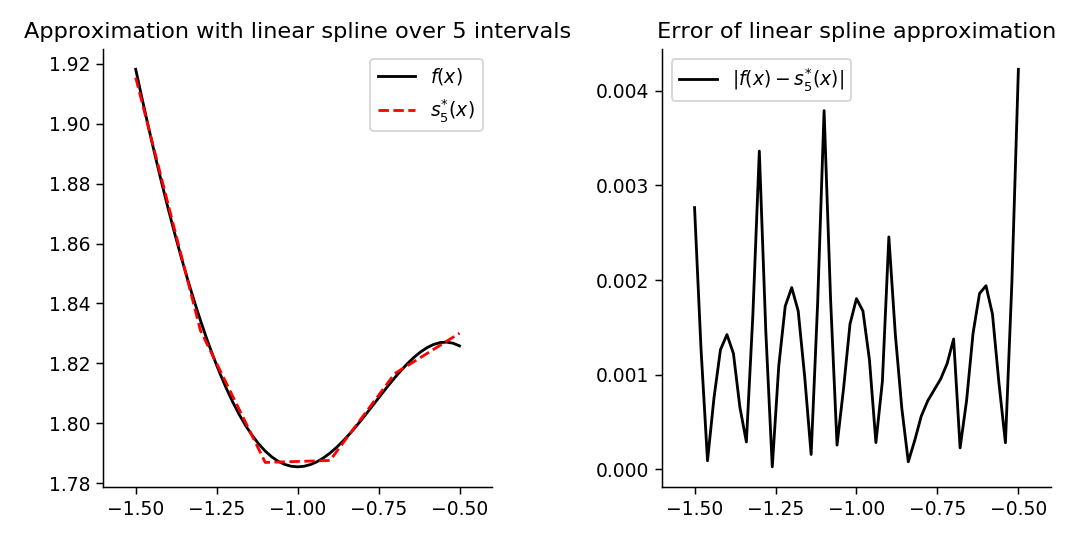

In [35]:
s_grid = array([s.subs(x, xi) for xi in x_grid])
s_err_grid = np.abs(f_grid - s_grid)

fig4, axes4 = plt.subplots(1, 2, sharex=True, figsize=(8, 4))

for ax in axes4:
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

axes4[0].set_xlim(a-0.1, b + 0.1)

axes4[0].plot(x_grid, f_grid, color='black', label='$f(x)$')
axes4[0].plot(x_grid, s_grid, '--', color='red', label='$s_5^{*}(x)$')

axes4[0].set_title('Approximation with linear spline over 5 intervals')
axes4[1].plot(x_grid, s_err_grid, color='black', label='$|f(x)-s_5^{*}(x)|$')
axes4[1].set_title('Error of linear spline approximation')
axes4[0].legend()
axes4[1].legend()
plt.tight_layout();

# Сравнение методов и выводы

# Add text

|Метод| Чем аппроксимируем | Cр. кв. погрешность  |
|-----|--------------------|----------------------|
|ИМНК | Полином 2го порядка| $7,58\cdot 10^{-3}$  |
|ИМНК | Полином 3го порядка| $2,7\cdot10^{-3}$    |
|ИМНК | Сплайн 1го порядка | $1,43 \cdot 10^{-3}$ |
|ТМНК | Полином 2го порядка| $9,53\cdot 10^{-3}$  |
|ТМНК | Полином 3го порядка| $3,36\cdot 10^{-3}$  |

---

In [24]:
f1 = log(1 + sqrt(x))
a1, b1 = 0, 1

In [25]:
integral_poly_ls(f1, a1, b1, 2, ret_error=True)

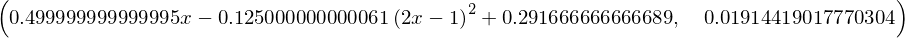

In [26]:
integral_legendre_ls(f1, a1, b1, 2, ret_error=True)

In [27]:
ordinary_ls(f1, linspace(a1, b1, n+1), 2, ret_error=True)

In [36]:
linear_spline_approximate(f1, linspace(a1, b1, 6), ret_comps=True, ret_error=True)

((array([ 0.12310626,  0.38583007,  0.49040422,  0.57564176,  0.63961798,
          0.69390568]),
  [Piecewise((-5.0*x + 1.0, And(x <= 0.2, x >= 0.0)), (0, True)),
   Piecewise((5.0*x, And(x < 0.2, x >= 0.0)), (-5.0*x + 2.0, And(x <= 0.4, x >= 0.2)), (0, True)),
   Piecewise((5.0*x - 1.0, And(x < 0.4, x >= 0.2)), (-5.0*x + 3.0, And(x <= 0.6, x >= 0.4)), (0, True)),
   Piecewise((5.0*x - 2.0, And(x < 0.6, x >= 0.4)), (-5.0*x + 4.0, And(x <= 0.8, x >= 0.6)), (0, True)),
   Piecewise((5.0*x - 3.0, And(x < 0.8, x >= 0.6)), (-5.0*x + 5.0, And(x <= 1.0, x >= 0.8)), (0, True)),
   Piecewise((5.0*x - 4.0, And(x <= 1.0, x >= 0.8)), (0, True))]),
 0.0098853707393292724)